# Data Challenge : Predicting lung cancer survival time by OWKIN

### Références :

-https://arxiv.org/pdf/1906.01908.pdf

-https://scikit-survival.readthedocs.io/en/stable/

-https://github.com/havakv/pycox

-https://nbviewer.org/github/havakv/pycox/blob/master/examples/cox-ph.ipynb

-https://lucris.lub.lu.se/ws/portalfiles/portal/5440161/5385348.pdf



## Introduction

Le but de ce data challenge est de développer des méthodes de prédiction du temps de survie de patients souffrant du cancer des poumons. Nous mettrons en oeuvre différentes méthodes de machine learning adaptées à l'analyse de survie, ainsi que des méthodes plus élaborées de Deep Learning. Intéressons-nous dans un premier temps aux données dont nous disposons.

## Features

Pour chaque patient, nous disposons de données cliniques ainsi que de données issues de la segmentation d'images provenant de radios de tumeurs cancéreuses

In [1]:
import numpy as np
import pandas as pd

y_init = pd.read_csv(r"ytrain.csv", index_col=0).sort_index()
y_init.head()

,SurvivalTime,Event
PatientID,,
2,638,0
3,421,0
4,465,1
5,1295,1
7,1393,0


In [2]:
df = pd.read_csv(r"xtrain\features\radiomics.csv", header=1, na_filter=True, skip_blank_lines=True, index_col=0).iloc[1:,:].sort_index()
clinical_data = pd.read_csv(r"xtrain\features\clinical_data.csv", index_col=0).sort_index().drop(["Mstage", "Histology", "SourceDataset"], axis=1)
clinical_data.index = df.index
clinical_data.age = clinical_data.age.fillna(np.mean(clinical_data.age))

df = df.join(clinical_data, how='left')
df["SurvivalTime"], df["Event"] = y_init.SurvivalTime.ravel(), y_init.Event.ravel()
df.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Nstage,Tstage,age,SurvivalTime,Event
002,0.024239,0.208753,100.682670,1.685735,0.593213,26352.063215,0.143385,183911.0,1.823932e+09,2.818278,...,1342.009256,0.000710,938.104181,0.003537,6567.332842,0,3,59.4223,638,0
003,0.014520,0.074913,178.117938,2.372178,0.421554,3007.456844,0.708512,4352.0,9.350766e+08,5.194189,...,731.875365,0.004741,695.615307,0.006145,901.956835,3,1,77.0986,421,0
004,0.022972,0.187502,133.895482,1.747154,0.572359,19410.111759,0.176282,110220.0,6.019421e+09,4.777084,...,1431.057216,0.001459,1208.546317,0.003430,3740.268350,0,3,84.5722,465,1
005,0.030597,0.332627,39.319207,1.443269,0.692871,2824.554343,0.346954,8177.0,7.031788e+07,2.178197,...,1328.848441,0.000986,816.256111,0.005828,10016.147961,0,2,71.8439,1295,1
007,0.024970,0.221540,97.989795,1.652657,0.605086,26355.120648,0.139177,189478.0,3.800057e+09,3.126632,...,1264.678549,0.001025,879.772376,0.004216,6675.271359,0,4,60.7283,1393,0


Certaines variables ont une variance très faible et n'apportent pas d'information intéressante (voir section pycox), on peut donc les éliminer.

In [3]:
print(df.var())
df = df.drop(['original_shape_Compactness1', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis'], axis = 1)

original_shape_Compactness1                     3.860165e-05
original_shape_Compactness2                     1.310154e-02
original_shape_Maximum3DDiameter                1.262617e+03
original_shape_SphericalDisproportion           1.034138e-01
original_shape_Sphericity                       1.021760e-02
original_shape_SurfaceArea                      1.214612e+08
original_shape_SurfaceVolumeRatio               2.748201e-02
original_shape_VoxelVolume                      6.784925e+09
original_firstorder_Energy                      2.594952e+19
original_firstorder_Entropy                     8.020348e-01
original_firstorder_Kurtosis                    1.827891e+02
original_firstorder_Maximum                     1.590979e+05
original_firstorder_Mean                        2.592946e+04
original_firstorder_MeanAbsoluteDeviation       7.038470e+03
original_firstorder_Median                      3.689866e+04
original_firstorder_Minimum                     1.047505e+04
original_firstorder_Rang

In [4]:
#Features, response
X, y = df.drop(["Event","SurvivalTime"], axis=1), df[["Event","SurvivalTime"]].to_numpy()
#y must be a list of tuples
y = [(bool(event), survivaltime) for event, survivaltime in y]
#and a structured array
y = np.array(y, dtype=[('Event', '?'), ('SurvivalTime', '<f8')])

# Analyse de survie

La particularité de ces données est qu'elles sont censurées, c'est-à-dire que certains individus sortent de l'étude avant que l'on enregistre l'évenement qui nous intéresse. En d'autres termes, certains patients ne fournissent pas un temps de survie relatif au cancer du poumon puisqu'un autre évement se produit (mort non liée au cancer, guérison, ...).
Cette particularité nous empêche d'appliquer des méthodes statistiques classiques, on va donc dans un premier temps se tourner vers des outils d'analyse de survie, dans un premier temps implémentés dans les packages `scikit-survival` et `lifelines`.
Dans un second temps, nous essaierons d'appliquer des méthodes plus poussées de Deep Learning.


# Partie 1 : Apprentissage statistique

Le package `scikit-survival` implémente de nombreux outils pour l'analyse de survie, nous allons en explorer une partie.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import ShuffleSplit, GridSearchCV

def score_survival_model(model, features, response):
    prediction = model.predict(features)
    result = concordance_index_censored(response['Event'], response['SurvivalTime'], prediction)
    return result[0]

## Random Survival Forest

In [597]:
from sksurv.ensemble import RandomSurvivalForest
estimator = RandomSurvivalForest()
estimator.fit(X_train, y_train)
estimator.score(X_test,y_test)

0.6328456819254366

In [116]:
pipeline = make_pipeline(StandardScaler(), estimator)
param_grid = {"n_estimators":[420, 410], "min_samples_split":[15]}
gridsearch = GridSearchCV(RandomSurvivalForest(), param_grid, scoring=score_survival_model, n_jobs=4, refit=False)
gridsearch.fit(X,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'min_samples_split': 15, 'n_estimators': 410}
0.6672513741644902


## Gradient Boosting

In [598]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
estimator = GradientBoostingSurvivalAnalysis(loss='squared', n_estimators=15)
estimator.fit(X_train, y_train)
estimator.score(X_test,y_test)
#0.74

0.5797546012269938

In [109]:
pipeline = make_pipeline(StandardScaler(), estimator)
param_grid = {
    "loss":['squared'], 
    "learning_rate" : [1], 
    "n_estimators" : [15, 300],
    "min_samples_split" : [2, 4, 10],
    "max_depth" : [30],
    "max_features":[None],
    "subsample" : [0.2],
    "dropout_rate" :  [0]
}

gridsearch = GridSearchCV(GradientBoostingSurvivalAnalysis(), param_grid, scoring=score_survival_model, n_jobs=3, refit=False)
gridsearch.fit(X,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'dropout_rate': 0.0, 'learning_rate': 1, 'loss': 'squared', 'max_depth': 30, 'max_features': None, 'min_samples_split': 10, 'n_estimators': 15, 'subsample': 0.2}
0.5259698987795914


C:\Users\lepau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.48830275 0.47628973 0.4837323  ... 0.36564404 0.36527791 0.36919438]
  warnings.warn(


## Survival Support Vector Machine

In [84]:
from sksurv.svm import FastSurvivalSVM
estimator = FastSurvivalSVM()
estimator.fit(X_train, y_train)
estimator.score(X_test,y_test)

0.593103448275862

In [86]:
param_grid = {'alpha': 2. ** np.arange(-10, 1, 1), 'rank_ratio':np.linspace(0,1,5)}
gridsearch = GridSearchCV(FastSurvivalSVM(), param_grid, scoring=score_survival_model, n_jobs=4, refit=False, cv=6)
gridsearch.fit(X,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)

{'alpha': 0.0009765625, 'rank_ratio': 0.0}
0.5710622348929676


Le package `lifelines` implémente lui aussi quelques méthodes intéressantes

## Penalized Cox's proportional hazard model

In [25]:
import numpy as np 
from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_index, test_index = next(sss.split(df.index)) 

In [26]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
cph.print_summary(3)
cph.score(df.iloc[test_index,], scoring_method='concordance_index')

<lifelines.CoxPHFitter: fitted with 210 total observations, 99 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Event'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 210
number of events observed = 111
   partial log-likelihood = -497.083
         time fit was run = 2022-01-17 12:40:01 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
original_shape_Compactness2                   0.045      1.046      3.342           -6.506            6.596                0.001              732.003
original_shape_Maximum3DDiameter              0.002      1.002      0.009           -0.015            0.019                0.985                1.019
original_shape_SphericalDisproportion        -0.239      0.788      1.207           -2.605            2.128                0.074                8.396
original_shape_Sphericity                    -0.481      0.618      5.484          -11.229           10.268                0.000            28785.018
original_shape_SurfaceArea                   -0.000      1.000      0.000           -0.000            0.000                1.000                1.000
original_shape_SurfaceVolumeRatio             2.183      8.870      2.060           -1.855            6.220                0.156              502.838
original_shape_VoxelVolume                    0.000      1.000      0.000           -0.000            0.000                1.000                1.000
original_firstorder_Energy                   -0.000      1.000      0.000           -0.000            0.000                1.000                1.000
original_firstorder_Entropy                  -0.208      0.812      0.688           -1.557            1.141                0.211                3.128
original_firstorder_Kurtosis                  0.004      1.004      0.013           -0.022            0.030                0.979                1.031
original_firstorder_Maximum                   0.000      1.000      0.001           -0.002            0.002                0.998                1.002
original_firstorder_Mean                      0.002      1.002      0.004           -0.005            0.010                0.995                1.010
original_firstorder_MeanAbsoluteDeviation     0.001      1.001      0.007           -0.012            0.014                0.988                1.015
original_firstorder_Median                   -0.000      1.000      0.003           -0.006            0.005                0.994                1.005
original_firstorder_Minimum                   0.003      1.003      0.004           -0.005            0.010                0.995                1.010
original_firstorder_Range                     0.000      1.000      0.001           -0.002            0.002                0.998                1.002
original_firstorder_RootMeanSquared          -0.002      0.998      0.004           -0.009            0.006                0.991                1.006
original_firstorder_Skewness                  0.174      1.190      0.144           -0.108            0.456                0.898                1.577
original_firstorder_StandardDeviation         0.001      1.001      0.007           -0.013            0.015                0.987                1.015
original_firstorder_Uniformity                2.391     10.924      7.051          -11.428           16.210                0.000            1.096e+07
original_firstorder_Variance                  0.000      1.000      0.000           -0.000            0.000                1.000                1.000
original_glcm_Autocorrelation                 0.001      1.001      0.002           -0.002            0.004             

0.6613934702120499

In [90]:
from sksurv.metrics import concordance_index_censored

args = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 6]
scores = []
for arg in args:
    cph = CoxPHFitter(penalizer=arg)
    cph.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
    scores.append((arg, cph.score(df.iloc[test_index,], scoring_method='concordance_index')))

print(max(scores, key = lambda x:x[1]))

C:\Users\lepau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lifelines\fitters\coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
C:\Users\lepau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lifelines\fitters\coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


(1, 0.6960619320094245)


Notre modèle atteint une erreur de validation de 0.69. Le modèle détecte que certaines variables ont une très faible variance, il est donc judicieux de les éliminer dès la phase de pré-traitement.

Regardons rapidement quelques modèles supplémentaires.



## Weibull AFT

In [13]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer=0.01)
aft.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
aft.score(df.iloc[test_index,], scoring_method='concordance_index')

0.6600471221810839

In [9]:
from sklearn.model_selection import GridSearchCV

args = [0.01, 0.1, 1, 2, 4, 6]
scores = []
for arg in args:
    aft = WeibullAFTFitter(penalizer=arg)
    aft.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
    scores.append((arg, aft.score(df.iloc[test_index,], scoring_method='concordance_index')))

print(max(scores, key = lambda x:x[1]))

(1, 0.6957253450016829)


## Aalen Additive Model

In [7]:
from lifelines import AalenAdditiveFitter

aaf = AalenAdditiveFitter(coef_penalizer=0.01)
aaf.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
aaf.score(df.iloc[test_index,], scoring_method='concordance_index')

0.495960955907102

In [21]:
from sklearn.model_selection import GridSearchCV

args = [0.01, 0.1, 1, 2, 4, 6]
scores = []
for arg in args:
    aaf = AalenAdditiveFitter(coef_penalizer=arg)
    aaf.fit(df.iloc[train_index,], duration_col='SurvivalTime', event_col='Event')
    scores.append((arg, aaf.score(df.iloc[test_index,], scoring_method='concordance_index')))

print(max(scores, key = lambda x:x[1]))

(0.1, 0.505385392123864)


Ces deux derniers modèles sont moins performants.

## Partie 2 : Deep Learning

## DeepSurv (pytorch)

Nous allons utiliser une méthode d'apprentissage profond adaptée à l'analyse de survie et implémentée dans le package `pycox`. Cette méthode demande dans un premier temps un gros pré-traitement des données.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
df_train = df
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,...,original_glrlm_RunPercentage,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Nstage,Tstage,age,SurvivalTime,Event
002,0.208753,100.682670,1.685735,0.593213,26352.063215,0.143385,183911.0,1.823932e+09,2.818278,20.544380,...,0.608142,1342.009256,938.104181,0.003537,6567.332842,0,3,59.4223,638,0
003,0.074913,178.117938,2.372178,0.421554,3007.456844,0.708512,4352.0,9.350766e+08,5.194189,2.291400,...,0.943351,731.875365,695.615307,0.006145,901.956835,3,1,77.0986,421,0
004,0.187502,133.895482,1.747154,0.572359,19410.111759,0.176282,110220.0,6.019421e+09,4.777084,5.268457,...,0.740312,1431.057216,1208.546317,0.003430,3740.268350,0,3,84.5722,465,1
005,0.332627,39.319207,1.443269,0.692871,2824.554343,0.346954,8177.0,7.031788e+07,2.178197,49.581787,...,0.501632,1328.848441,816.256111,0.005828,10016.147961,0,2,71.8439,1295,1
007,0.221540,97.989795,1.652657,0.605086,26355.120648,0.139177,189478.0,3.800057e+09,3.126632,12.867960,...,0.605997,1264.678549,879.772376,0.004216,6675.271359,0,4,60.7283,1393,0


In [8]:
cols_leave = ['Nstage', 'Tstage']
cols_standardize = list(np.copy(df.columns))
cols_standardize.remove('SurvivalTime')
cols_standardize.remove('Event')
cols_standardize.remove('Nstage')
cols_standardize.remove('Tstage')

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [9]:
get_target = lambda df: (df['SurvivalTime'].values, df['Event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [10]:
netold = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = 1, batch_norm = True,
                            dropout = 0.1, output_bias = False)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features = x_train.shape[1], out_features = 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(in_features = 32, out_features = 16),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(in_features = 16, out_features = 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(in_features = 8, out_features = 1)
)

modelDeepSurv = CoxPH(net, tt.optim.Adam)

0.006579332246575716

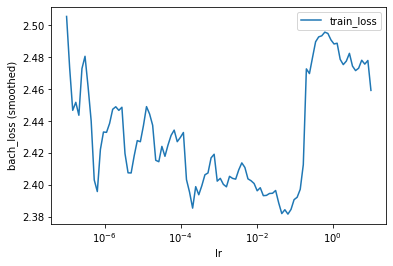

In [11]:
batch_size = 20
lrfinder = modelDeepSurv.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()
lrfinder.get_best_lr()

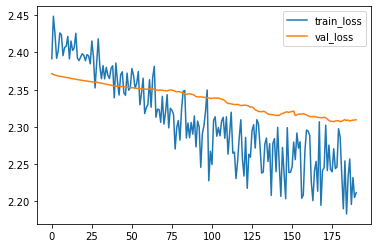

In [13]:
modelDeepSurv.optimizer.set_lr(0.0001)
epochs = 200
callbacks = [tt.callbacks.EarlyStopping()] #permet un arrêt prématuré lorsque le modèle ne s'améliore plus
log = modelDeepSurv.fit(x_train, y_train, batch_size, epochs, callbacks, verbose = False,
                val_data=val, val_batch_size=batch_size)
_ = log.plot()

Prédictions de la fonction de survie pour 5 patients :

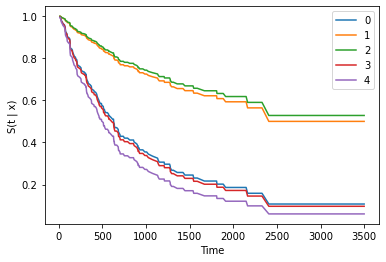

In [14]:
_ = modelDeepSurv.compute_baseline_hazards()
surv = modelDeepSurv.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [15]:
surv = modelDeepSurv.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.6723518850987432

On peut aussi essayer d'exploiter les données brutes (disponibles dans les fichiers images.npz)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

In [201]:
import numpy as np
import os

for root, dirs, files in os.walk("xtrain\images"):
    pass

images = np.array([
    np.load(f'xtrain\images\{patient}')['scan'] for patient in files
])

y_images = np.array(df[["SurvivalTime","Event"]])

In [206]:
from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
train_index, test_index = next(sss.split(df.index))
sss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(sss.split(test_index))

x_train = np.array(images[train_index], dtype = np.float32)
x_val = np.array(images[val_index], dtype = np.float32)
x_test = np.array(images[test_index], dtype = np.float32)

y_train = (y_images[train_index,0], y_images[train_index,1])
y_val =  (y_images[val_index,0], y_images[val_index,1])
y_test =  (y_images[test_index,0], y_images[test_index,1])


durations_test, events_test = y_test[0], y_test[1]
val = x_val, y_val


In [210]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 92, out_channels = 92, kernel_size = (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Conv2d(in_channels = 92, out_channels = 92, kernel_size = (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=(2, 2)),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(40572,1)
)

modelDeepL = CoxPH(net, tt.optim.Adam)

0.0001

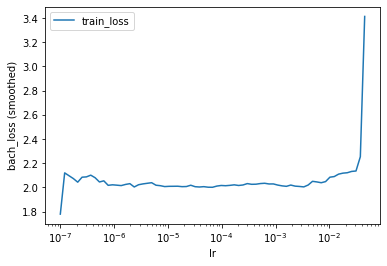

In [221]:
batch_size = 20
lrfinder = modelDeepL.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()
lrfinder.get_best_lr()

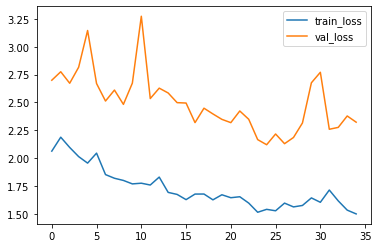

In [232]:
modelDeepL.optimizer.set_lr(0.0001)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = modelDeepL.fit(x_train, y_train, batch_size, epochs, callbacks, verbose = False,
                val_data=val, val_batch_size=batch_size)
_ = log.plot()

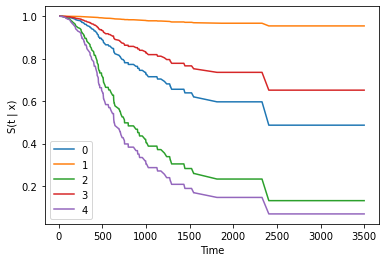

In [233]:
_ = modelDeepL.compute_baseline_hazards()
surv = modelDeepL.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [234]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.7139756944444444

## Prédictions

In [27]:
#Modèle
#model1 = RandomSurvivalForest(min_samples_split = 15, n_estimators = 410)
#model1 = GradientBoostingSurvivalAnalysis(loss='squared', n_estimators=15)
#model1 = FastSurvivalSVM(alpha=0.0009765625, rank_ratio=0)
#model1 = CoxPHSurvivalAnalysis(alpha=0.1)
#model1 = CoxnetSurvivalAnalysis(n_alphas=2100, max_iter=100000, l1_ratio=0.134, normalize=True, fit_baseline_model=True)
#model1.fit(X, y)

#cph = CoxPHFitter(penalizer=0.01)
#cph.fit(df, duration_col='SurvivalTime', event_col='Event')
aft = WeibullAFTFitter(penalizer=0.01)
aft.fit(df, duration_col='SurvivalTime', event_col='Event')
#aaf = AalenAdditiveFitter(coef_penalizer=0.1)
#aaf.fit(df, duration_col='SurvivalTime', event_col='Event')


<lifelines.CoxPHFitter: fitted with 300 total observations, 138 right-censored observations>

In [28]:
xtest = pd.read_csv(r"xtest\features\radiomics.csv", header=1, na_filter=True, skip_blank_lines=True, index_col=0).iloc[1:,:].sort_index()
clinical_data_test = pd.read_csv(r"xtest\features\clinical_data.csv", index_col=0).sort_index().drop(["Mstage", "SourceDataset", "Histology"], axis=1)
clinical_data_test.index = xtest.index
clinical_data_test.age = clinical_data_test.age.fillna(np.mean(clinical_data.age))
xtest = xtest.join(clinical_data_test, how='left')
xtest = xtest.drop(['original_shape_Compactness1', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis'], axis = 1)
xtest = pd.DataFrame(xtest, dtype = float)
xtest.head()

,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,...,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,Nstage,Tstage,age
000,0.266261,57.489129,1.554404,0.643333,2212.837670,0.438124,5085.0,1.352993e+09,5.187271,1.629014,...,131.906390,3908.379003,0.907087,561.862390,509.414582,0.012873,902.593149,0.0,1.0,78.0000
001,0.167986,80.012499,1.812351,0.551770,11154.501153,0.245677,45509.0,2.145183e+09,3.967976,6.376360,...,2195.164772,19760.450438,0.685239,1386.412943,1077.174331,0.005198,6439.704810,2.0,2.0,71.7153
006,0.361943,47.770284,1.403201,0.712656,4749.549217,0.256496,18561.0,8.860635e+08,4.273762,3.472753,...,682.712815,8622.175597,0.705785,826.187210,639.545171,0.005659,3723.024015,2.0,4.0,64.1615
009,0.112759,56.542020,2.069901,0.483115,7093.365690,0.376032,18942.0,9.108915e+09,5.067418,3.645805,...,652.071367,15924.101510,0.942025,344.205786,331.901212,0.024175,400.015847,0.0,2.0,50.0000
010,0.103893,104.192130,2.127184,0.470105,19717.446965,0.234968,84079.0,2.571251e+09,3.872285,11.289089,...,5133.442740,32760.999741,0.682228,1700.219255,1284.372657,0.002175,6146.883374,2.0,4.0,80.4819


In [29]:
predDf = pd.DataFrame()
#pred = model1.predict(xtest)
#pred = cph.predict_median(xtest)
#pred = cph.predict_expectation(xtest)
#pred = aft.predict_expectation(xtest)
pred = aft.predict_median(xtest)
#pred = aaf.predict_expectation(xtest)
#pred = aaf.predict_median(xtest)


predDf['SurvivalTime'], predDf["Event"] = pred, len(xtest)*[np.NaN]
predDf.index = xtest.index
predDf.to_csv(f"ytest_cph_expectation.csv")
predDf


,SurvivalTime,Event
000,1980.440136,NaN
001,760.899232,NaN
006,1148.947132,NaN
009,3350.763320,NaN
010,683.565072,NaN
...,...,...
411,2457.365055,NaN
412,2635.341687,NaN
413,1944.950889,NaN
415,1188.679307,NaN


### Prédictions DeepSurv

In [19]:
cols_leave = ['Nstage', 'Tstage']
cols_standardize = list(np.copy(xtest.columns))
cols_standardize.remove('Nstage')
cols_standardize.remove('Tstage')

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)

xtestdeepsurv = x_mapper.fit_transform(xtest).astype('float32')

In [38]:
surv = modelDeepSurv.predict_surv_df(xtestdeepsurv)
surv = modelDeepSurv.predict(xtestdeepsurv)
surv[:,0]

array([-0.38399327,  0.73362565,  0.8195259 , -0.9120016 ,  0.93163353,
       -0.04225035,  0.72329944, -0.22689195,  0.79348016, -0.5242315 ,
        0.58880305, -0.60838735, -0.03021522,  0.7186629 , -0.33730245,
       -0.18069233,  0.62707746, -0.28618485,  0.84595317,  0.7397485 ,
       -0.45998132,  0.81282246,  0.77633995,  0.8448131 , -0.2739975 ,
        0.46933937, -0.57967067,  0.58078086, -0.33440226,  0.25166425,
       -0.39022565,  0.89704126,  0.7520409 ,  0.8817526 , -0.4864322 ,
        0.8787781 , -0.16448991, -0.17852642,  0.47499353,  0.95287704,
        0.34683144,  0.7023119 ,  0.6787683 ,  0.8040755 , -0.44826853,
        0.35828656,  0.56241   ,  0.86610115,  0.9685901 , -0.07070924,
        0.5328079 , -0.48189437,  0.8265121 , -0.6478037 ,  0.73160607,
        1.0946292 , -0.34318662,  0.713709  ,  0.48901546,  0.6636543 ,
        0.5941843 ,  0.3234577 , -0.10430317,  0.5448223 , -0.48617077,
       -0.36706138,  0.7299622 ,  0.6291675 , -0.00494601,  0.75

In [48]:
predDf = pd.DataFrame()
predDf['SurvivalTime'], predDf["Event"] = np.exp(-surv[:,0]+7), len(xtestdeepsurv)*[np.NaN]
predDf.index = xtest.index
predDf.to_csv(f"ytest_deepsurv.csv")
predDf

,SurvivalTime,Event
000,1610.005981,NaN
001,526.564880,NaN
006,483.221100,NaN
009,2729.849121,NaN
010,431.974487,NaN
...,...,...
411,1666.449951,NaN
412,1848.638794,NaN
413,1167.270264,NaN
415,638.042603,NaN
